# Geographical Visualizations with Python

#### This script contains the following:
1. Importing libraries and data
2. Creating choropleth map
3. Result discussion

#### 1. Importing libraries and data

In [1]:
#importing libraries
import pandas as pd
import numpy as np
import os

In [2]:
#creating path for easier import
path = r'C:\Users\magia\NY CitiBike'

In [3]:
# importing dataset
df = pd.read_csv(os.path.join(path, '2. Data', 'Prepared Data', 'citibike_cleaned.csv'))

In [4]:
!pip install geopandas

In [5]:
import geopandas as gpd
from shapely.geometry import Point

# Create GeoDataFrame from station coordinates
geometry = [Point(xy) for xy in zip(df['start_station_longitude'], df['start_station_latitude'])]
gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")

# Load shapefile of NYC Neighborhood Tabulation
nyc_regions = gpd.read_file('nynta2020.shp') 

# Spatial join to get the region for each station
gdf_with_region = gpd.sjoin(gdf, nyc_regions, how="left", predicate="within")

C:\Users\magia\AppData\Local\Temp\ipykernel_8108\3370649646.py:12: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: EPSG:2263

  gdf_with_region = gpd.sjoin(gdf, nyc_regions, how="left", predicate="within")


In [6]:
# Reprojecting points GeoDataFrame to the CRS of nyc_regions
gdf = gdf.to_crs(nyc_regions.crs)

# Performing spatial join
gdf_with_region = gpd.sjoin(gdf, nyc_regions, how="left", predicate="within")

In [7]:
# confirming join
print(nyc_regions.columns)

Index(['BoroCode', 'BoroName', 'CountyFIPS', 'NTA2020', 'NTAName', 'NTAAbbrev',
       'NTAType', 'CDTA2020', 'CDTAName', 'Shape_Leng', 'Shape_Area',
       'geometry'],
      dtype='object')


In [8]:
# adding neighborhood names to stations gdf
gdf_with_region['neighborhood'] = gdf_with_region['NTAName']

In [9]:
print(gdf_with_region.columns)
print(gdf_with_region.head())

Index(['bike_id', 'weekday', 'start_hour', 'start_time', 'start_station_id',
       'start_station_name', 'start_station_latitude',
       'start_station_longitude', 'end_time', 'end_station_id',
       'end_station_name', 'end_station_latitude', 'end_station_longitude',
       'trip_duration', 'subscriber', 'birth_year', 'gender',
       'birth_year_label', '88+_years_old', 'geometry', 'index_right',
       'BoroCode', 'BoroName', 'CountyFIPS', 'NTA2020', 'NTAName', 'NTAAbbrev',
       'NTAType', 'CDTA2020', 'CDTAName', 'Shape_Leng', 'Shape_Area',
       'neighborhood'],
      dtype='object')
   bike_id weekday  start_hour           start_time  start_station_id  \
0    16013     Mon          18  2013-09-09 18:18:55               523   
1    15230     Thu          18  2013-09-12 18:38:53               257   
2    17942     Wed          19  2013-09-18 19:44:04               479   
3    19683     Sat          11  2013-09-28 11:54:37               527   
4    18024     Sat          18  20

#### 2. Creating choropleth map of trip counts per neighborhood using merged GeoDataFrame and neighborhood polygons

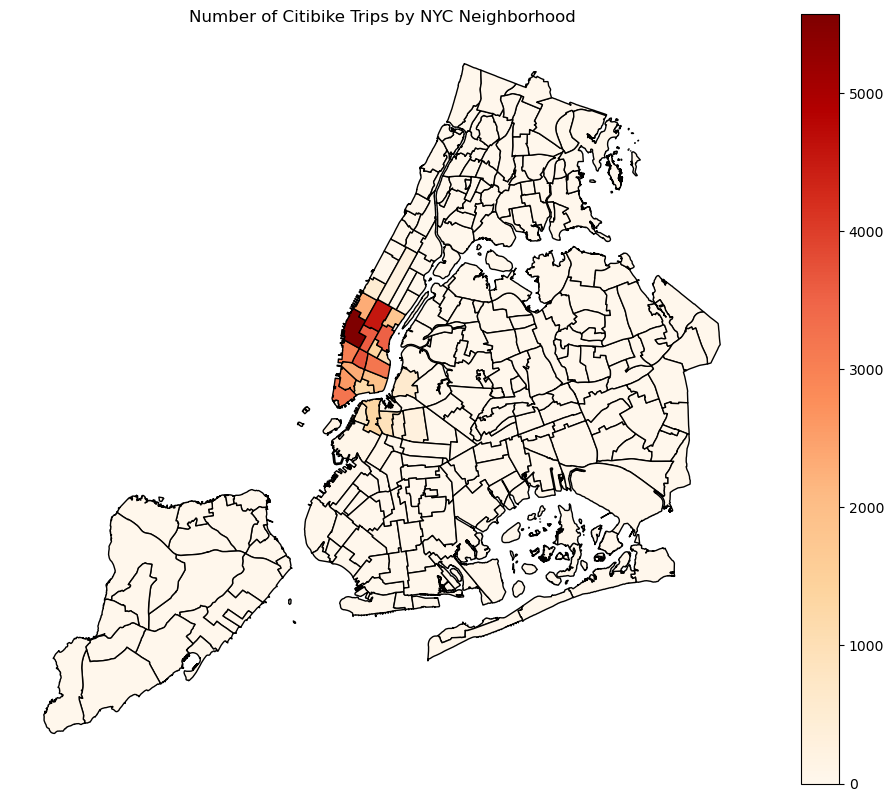

In [10]:
import matplotlib.pyplot as plt

# Group by neighborhood and count trips
trips_per_neighborhood = gdf_with_region.groupby('neighborhood').size().reset_index(name='trip_count')

# Merge trip counts back to the neighborhood polygons GeoDataFrame
nyc_regions = nyc_regions.merge(trips_per_neighborhood, left_on='NTAName', right_on='neighborhood', how='left')
nyc_regions['trip_count'] = nyc_regions['trip_count'].fillna(0)  # Replace NaNs with 0

# Plot choropleth
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
nyc_regions.plot(column='trip_count', ax=ax, legend=True, cmap='OrRd', edgecolor='black')
ax.set_title('Number of Citibike Trips by NYC Neighborhood')
ax.axis('off')
plt.show()

Citibike in 2013 was heavily concentrated in Lower Manhattan and parts of Brooklyn. Uptown, Queens, and the Bronx weren’t really part of the network yet — so it makes sense those areas show 0 trips (or NaNs).

In [11]:
!pip install folium

In [12]:
# Creating Folium Map centered on New York City
import folium

m = folium.Map(location=[40.7128, -74.0060], zoom_start=11)


In [13]:
import folium

# 1. Make sure nyc_regions GeoDataFrame has trip counts and is in WGS84
nyc_regions = nyc_regions.to_crs(epsg=4326)
nyc_regions['trip_count'] = nyc_regions['trip_count'].fillna(0)

# 2. Prepare trip counts DataFrame for folium
trip_counts_df = nyc_regions[['NTAName', 'trip_count']]

# 3. Create folium map centered on NYC
m = folium.Map(location=[40.7128, -74.0060], zoom_start=11)

# 4. Add Choropleth layer
folium.Choropleth(
    geo_data=nyc_regions.__geo_interface__,
    data=trip_counts_df,
    columns=['NTAName', 'trip_count'],
    key_on='feature.properties.NTAName',
    fill_color='OrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Number of Citibike Trips by Neighborhood'
).add_to(m)

# 5. Display the map
m

In [14]:
m.save(r'C:\Users\magia\NY CitiBike\4. Analysis\Visualizations\citibike_choropleth_map.html')

Within the areas where trips have occurred, *Chelsea* has the highest number of trips by far, followed by Midtown and Greenwich Village. After that come Tudor City and the Financial District, then the rest of Lower Manhattan and Downtown Brooklyn.

### 3. Discussing Results

The map effectively answered our initial question by highlighting the busiest areas, though it doesn’t yet reveal which exact stations are the busiest. Our next step will be to analyze whether these busiest areas are prominent as both trip start and end points, or primarily one or the other. For example, some stations might be busy only during morning commutes or only in the evening, while others may be busy in both directions. This analysis will provide deeper insights into customer usage patterns and peak times, enabling us to make more informed recommendations for Citibike’s operational planning.

To gain better insights, we will need temporal dimension and subscriber/non-subscriber info to see how groups use stations differently.